# Cleaning anomalies in time series per region slug



## Load  libraries

In [1]:
# %load first_cell.py
%reload_ext autoreload
%autoreload 2
from pathlib import Path
home = str(Path.home())

import sys
sys.path = sys.path + [f'{home}/.conda/envs/norm_env/lib/python37.zip', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/lib-dynload', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/site-packages']
sys.prefix = '/home/soniame/.conda/envs/norm_env'

from paths import RAW_PATH, TREAT_PATH, OUTPUT_PATH, FIGURES_PATH

#from copy import deepcopy
#import numpy as np
#import pandas as pd
#pd.options.display.max_columns = 999
#import yaml
#import matplotlib.pyplot as plt 
#from datetime import datetime
#
#import warnings
#warnings.filterwarnings('ignore')
#
## Plotting
#import plotly
#import plotly.graph_objs as go
#import cufflinks as cf
#plotly.offline.init_notebook_mode(connected=True)
#
#def iplottitle(title, width=40):
#    return '<br>'.join(textwrap.wrap(title, width))
#import seaborn as sns
#import matplotlib.pyplot as plt
#sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
#
#import plotnine as p9
#from mizani.breaks import date_breaks
#from mizani.formatters import date_format
#p9.theme_set(p9.theme_linedraw()) # default theme
#
## Setting cufflinks
#import textwrap
#import cufflinks as cf
#cf.go_offline()
#cf.set_config_file(offline=False, world_readable=True)
#import yaml
#from jinja2 import Template
#cf.themes.THEMES['custom'] = yaml.load(open('cufflinks_template.yaml', 'r'))
#
## Manipulation 
#from siuba import *
#
## Outliers
#from adtk.data import validate_series
#from adtk.transformer import DoubleRollingAggregate
#from adtk.visualization import plot
#from adtk.pipe import Pipeline
#from adtk.detector import QuantileAD
#from adtk.transformer import ClassicSeasonalDecomposition

## Load data

### dahsboard data

## Process creation

In [185]:

from pathlib import Path
import numpy as np
import pandas as pd
from functools import reduce
from loguru import logger
from datetime import datetime, timedelta
from siuba import *

# plots
import matplotlib.pyplot as plt 
import plotnine as p9
from mizani.breaks import date_breaks
from mizani.formatters import date_format
p9.theme_set(p9.theme_linedraw()) # default theme

from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import LevelShiftAD, PersistAD, GeneralizedESDTestAD, SeasonalAD, AutoregressionAD
from tsmoothie.smoother import DecomposeSmoother

from src import utils
conn = utils.connect_athena(path='../configs/athena.yaml')


../src/utils.py:158: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


### Functions

#### init functions

In [34]:
# Initialize functions

def _validate_series(df, column_name):
    """
    A function to validate series
    
    Parameters
        ----------
        df : data frame 
            Data frame with column to validare. The data frame requires
            columns region_slug and date to be sorted. Date is defined as
            the index.
        column_name : str
            Name of the column to validate
    """

    logger.debug(f"... validating {column_name}...\n")
    y_df = df.sort_values(['date'])[['date', column_name]].set_index('date')
    s = validate_series(y_df)
    
    return s

#### Anomalies functions

In [55]:
### Outlier functions
def _outlier_persist_ad(s, target_column_name, c_param = 4, window_param = 14):
    
    try :
        persist_ad = PersistAD(c=c_param, side='both', window = window_param)
        anomalies = persist_ad.fit_detect(s)
    except : 
        logger.debug('!! No Persist !!')
        anomalies = s
        anomalies[target_column_name] = 0
    finally : 
        anomalies = anomalies \
            .rename(columns={target_column_name:'anomaly_persist'}) \
            .reset_index()   
    
    return anomalies

def _outlier_gesdt_ad(s, target_column_name, alpha_param = 0.3, window_param = 14):
    
    try :
        esd_ad = GeneralizedESDTestAD(alpha=alpha_param)
        anomalies = persist_ad.fit_detect(s)
    except : 
        logger.debug('!! No gesdt !!')
        anomalies = s 
        anomalies[target_column_name] = 0
    finally : 
        anomalies = anomalies \
            .rename(columns={target_column_name:'anomaly_gesdt'}) \
            .reset_index()   
    
    return anomalies

def _outlier_seasonal_ad(s, target_column_name, c_param = 3.0, window_param = 14):
    
    try : 
        seasonal_ad = SeasonalAD(c=c_param, side="both")
        anomalies = seasonal_ad.fit_detect(s)
    except : 
        logger.debug('!! No Seasonal !!')
        anomalies = s
        anomalies[target_column_name] = False
    finally : 
        anomalies = anomalies \
            .rename(columns={target_column_name:'anomaly_seasonal'}) \
            .reset_index()   
        
    return anomalies     

def _outlier_autregr_ad(s, target_column_name, c_param = 3.0, n_steps_param = 4, step_size_param=7):
    
    try : 
        autoregression_ad = AutoregressionAD(n_steps=n_steps_param, step_size=step_size_param, c=c_param)
        anomalies = autoregression_ad.fit_detect(s)
    except : 
        logger.debug('!! No Seasonal !!')
        anomalies = s    
        anomalies[target_column_name] = 0
    finally : 
        anomalies = anomalies \
            .rename(columns={target_column_name:'anomaly_autor'}) \
            .reset_index()   
        
    return anomalies     

def _anomalies_detector(s, target_column_name):
    """
    The function runs three algorithms to detect outliers.
    
    Parameters
        ----------
        s : data frame 
            Description
        target_column_name : str
            Target column name to detect outliers
    """
    
    anomalies = _outlier_persist_ad(s, target_column_name) \
        .merge(_outlier_seasonal_ad(s, target_column_name)) \
        .merge(_outlier_autregr_ad(s, target_column_name)) \
        .fillna(0)
    
    anomalies['anomaly_sum'] = \
        (anomalies['anomaly_persist']) + \
        (anomalies['anomaly_seasonal'] == True) +  \
        (anomalies['anomaly_autor'])
    anomalies.head(2)
      
    return(anomalies[anomalies.anomaly_sum > 0])


# 2. Find anomalies
def _find_anomalies(df, anomaly_vote_minimun, target_column_name, print_report=True):

    logger.debug("\n... finding outliers ...")
    
    # validate series
    s = _validate_series(df, target_column_name)
    #plot(s)
    
    # join anomialies detector
    df_anomaly = df.merge(_anomalies_detector(s, target_column_name), how = 'left')
    anomalies_cnt = sum(df_anomaly.anomaly_sum >= anomaly_vote_minimun)
    anomalies_date = df_anomaly[df_anomaly.anomaly_sum >= anomaly_vote_minimun].date.to_list()
    
    logger.debug('Number of anomalies found: ' + str(anomalies_cnt))  
    logger.debug(anomalies_date)
    
    if print_report:
        logger.debug('... printing anomalies report ...\n')
        print(_plot_anomalies(df_anomaly, 
                              observed_column = target_column_name,
                              anomalies_cnt=anomalies_cnt))
    
    return(df_anomaly, anomalies_date)


#### Imputation functions

In [56]:
### Imputation functions
def _decompose_lowess(variable_smooth, missing_values, smooth_fraction=0.2):
    # operate smoothing
    smoother = DecomposeSmoother(smooth_type='lowess', 
                                 periods=7,
                                 smooth_fraction=smooth_fraction)
    smoother.smooth(variable_smooth)

    result = variable_smooth
    smooth_result = smoother.smooth_data[0]
    result[missing_values] = smooth_result[missing_values]
    
    return result

# 3. Impute anomalies
def _impute_anomalies(observed_column, 
                      date_column,
                      anomaly_sum_column, 
                      anomaly_vote_minimun, 
                      smooth_fraction = 0.2):
    """
    The function runs several algorithms to detect level shifts.
    
    Parameters
        ----------
        observed_column : data frame 
            Description
        date_column : str
            Description
        nomaly_sum_column : str
            Description
        anomaly_vote_minimun : str
            Description
        smooth_fraction : str
            Description
    """
    
    logger.debug("\n... imputing outliers ...")
    
    # building data frame to impute
    df_impute = pd.DataFrame({
        'date': date_column,
        'observed_column': observed_column,
        'anomaly_sum': anomaly_sum_column,
        'observed_missing': observed_column
    }) 
    # create missing values
    df_impute.loc[df_impute.anomaly_sum >= anomaly_vote_minimun, 'observed_missing'] = None
    df_impute.loc[df_impute.observed_column < 0, 'observed_missing'] = None

    df_impute = df_impute.set_index('date')
    
    # algorithms to impute
    df_impute =  df_impute \
        .assign(RollingMean=df_impute.observed_missing \
                    .fillna(df_impute.observed_missing \
                            .rolling(30, min_periods=1,) \
                            .mean()) ) \
        .assign(RollingMedian=df_impute.observed_missing \
                    .fillna(df_impute.observed_missing \
                            .rolling(30, min_periods=1,) \
                            .median()) ) \
        .assign(Polinomial=df_impute.observed_missing \
                    .interpolate(method='polynomial', order = 5)) \
        .assign(Loess=_decompose_lowess(df_impute.observed_column, 
                                        df_impute.observed_missing.isna(),
                                        smooth_fraction = smooth_fraction)) 


    return df_impute


#### Shift functions

In [113]:
### Shift functions

def _c_param(region_slug, 
             athena_path = '/home/soniame/shared/spd-sdv-omitnik-waze/corona'):
    
    c_region = pd.read_csv(athena_path + '/raw/cities_c_iqr.csv') \
        .rename(columns={'city':'region_slug'})
    
    
    if region_slug in c_region.region_slug:
        c_param = c_region[c_region.region_slug == region_slug].c_low_p1.to_list()[0]
    else :
        c_param = 3
        
    logger.debug('c_param: ' + str(c_param))
    return c_param

def _level_shift_detection(s, c_param = 6.0, window_param = 14, print_plot = False):
    """
    Level shift or change point detection. This function uses the function 
    LevelShiftAD from ADTK library.
    
    Parameters
    ----------
        s : validated serie object 
            Description
        c_param : dbl, default 6.0
            Description
        window_param : int, default 14
            Description
        print_plot: bool, default True
            Description
    """
    #logger.debug(f"... detecting shift c{c_param}-w{window_param}...")
    level_shift_ad = LevelShiftAD(c=c_param, side='both', window=window_param)
    shifts = level_shift_ad.fit_detect(s)
    
    if print_plot:
        plot(s, anomaly=shifts, anomaly_color='red')
    
    return shifts


def _run_shift_grid(s, observed_variable, c_param, low_grid = .20, upp_grid = .60):
    """
    Run shift detector grid for several values. 
    
    Parameters
    ----------
        s : validated serie object 
            Description
        observed_variable : validated serie object 
            Description    
        c_param : dbl, default 6.0
            Description
        low_grid : int, default 14
            Description
        upp_grid: bool, default True
            Description
    """
    logger.debug(f"\n... shift level running grid  ...")
    
    shift_l = list()
    for cp in [round(c_param-c_param*(upp_grid), 4), 
               round(c_param-c_param*(low_grid), 4), 
               c_param, 
               round(c_param+c_param*(low_grid), 4), 
               round(c_param+c_param*(upp_grid), 4) ]:
        for wdw in [14, 15, 16, 17, 18]:    
            shift = _level_shift_detection(s, c_param = cp,
                                           window_param=wdw, 
                                           print_plot = False) \
                    .rename(columns={observed_variable:f'shift_c{cp}_w{wdw}'})
            shift_l.append(shift)
    len(shift_l)    
    df_grid = reduce(lambda df1, df2: df1.merge(df2, on='date'), shift_l)
    df_grid.shape
    
    logger.debug(f"Total combinations: {len(shift_l)}")
    
    return df_grid

def _shifted_adtk_ts(s, column_name, agg="std", window=(3,3), diff="l2", print_plot=True):
    # shift ts level
    
    s_transformed = DoubleRollingAggregate(
        agg=agg,
        window=window,
        diff=diff).transform(s).rename(columns={column_name:'adtk_shift'})
    
    if print_plot:
        plot(pd.concat([s, s_transformed], axis=1))
        
    return s_transformed


def _shift_sum(df_shift):
    df_shift_sum = (df_shift.reset_index()
     >> filter(_.date > '2020-03-31',
              ((_.date < '2020-12-15') | (_.date > '2021-01-15')))
     >> gather('variable', 'value', -_.date)
     >> filter(_.variable.str.startswith('shift'))
     >> group_by('date')
     >> summarize(shift_sum = _.value.sum())
     >> filter(_.shift_sum > 0)
     >> arrange('date')
    )

    return df_shift_sum

def _rolling_manual_sum(tab, days_before= 0, days_after = 7):
    rolling_sum = list()
    for dat in tab.date:
        date_init = dat + timedelta(days=days_before)
        date_end  = dat + timedelta(days=days_after)
        #logger.debug( str(dat ) + ' to ' + str(dat + timedelta(days=7)))
        sum_sum = tab[(tab.date >= date_init) & (tab.date < date_end)].suma.sum()
        rolling_sum.append(sum_sum)

    return rolling_sum

def _shift_window_sum(df_shift, days_before= 0, days_after = 7):
    tab = (df_shift.reset_index()
     >> filter(_.date > '2020-03-31', 
              ((_.date < '2020-12-15') | (_.date > '2021-01-15')))
     >> gather('variable', 'value', -_.date)
     >> filter(_.variable.str.startswith('shift'))
     >> arrange(_.date)
     >> group_by('date')
     >> summarize(suma = _.value.sum())
     >> ungroup()
    )
    tab['shift_sum'] = _rolling_manual_sum(tab, 
                                             days_before= days_before, 
                                             days_after = days_after)
    
    return tab[['date', 'shift_sum']]

def _initial_shift_date(df_shift_sum):

    shift_init = df_shift_sum[df_shift_sum.shift_sum == df_shift_sum.shift_sum.max()].date.min()
    
    logger.debug(f'Shift found at {shift_init}')
    
    return shift_init


def _shift_ts(shift_init, date_column, to_shift_column):
    
    # TODO: step_shift_before, step_shift_after
    # a two weeks both sided window
    shift_wdw_init = shift_init - timedelta(days=7)
    shift_wdw_end  = shift_init + timedelta(days=7)
    # level centered
    center_point = ((to_shift_column[(date_column >  shift_wdw_init) & 
                        (date_column <= shift_init)].mean()) -
                    (to_shift_column[(date_column >  shift_init) & 
                        (date_column <= shift_wdw_end)].mean())
                   )
    # change print to logger
    logger.debug('\n')  
    logger.debug('Center point: ' + str(center_point))
    
    shifted_column = to_shift_column
    shifted_column[ (date_column > shift_init) ] = \
        ( (to_shift_column[(date_column > shift_init)]) + center_point )
        
    return shifted_column   


def _shift_level_report(df_shift, df_shift_sum, observed_column, region_slug):
    
    df_shift=df_shift.reset_index()    
    df_shift['observed_column'] = observed_column
    df_gather = (df_shift
         >> gather('variable', 'value', -_['date', 'observed_column']) 
       )   
    tab = (df_gather
         >> mutate(value_rec = _.value.replace( 0, np.nan))
        )
    tab[['shift', 'cparam', 'window']] = tab['variable'].str.split('_',expand=True)
    gg_1 = (p9.ggplot(tab, p9.aes(x ='date', y = 'observed_column'))
     + p9.geom_line(size = 1) 
     + p9.geom_point(p9.aes(size = 'value_rec', color = 'value_rec')) 
     + p9.facet_grid('window ~ cparam')
     + p9.scale_size_continuous(range=(1.5, 1.5)) 
     + p9.theme(axis_text_x=p9.element_text(angle=90),
                figure_size=(8, 6) )
        )
    print(gg_1)
    
    gg_2 = (p9.ggplot(df_shift_sum, p9.aes(x ='date', y = 'shift_sum'))
     + p9.geom_col()
     + p9.theme(axis_text_x=p9.element_text(angle=90),
                figure_size=(8, 2) )
        )
    print(gg_2)
    
    #logger.debug(df_shift_sum[df_shift_sum.shift_sum == df_shift_sum.shift_sum.max()])
    

def _shift_level(df, 
                 column_name, 
                 c_param  = 3.0, 
                 low_grid = .20, 
                 upp_grid = .60, 
                 grid_days_before= 0, 
                 grid_days_after = 7,
                 print_report = False):

    logger.debug('\n')  
    logger.debug(f"... shifting levels for {column_name} ...")
    
    s = _validate_series(df.reset_index(), column_name=column_name)
    #plot(s)
    
    # running grid
    df_grid = _run_shift_grid(s, 
                            observed_variable = column_name,
                            c_param  = c_param, 
                            low_grid = low_grid, 
                            upp_grid = upp_grid)
    # grid summary
    df_grid_sum = _shift_sum(df_grid)
    #df_grid_sum = _shift_window_sum(df_grid, 
    #                                days_before= grid_days_before, 
    #                                days_after = grid_days_after)
    
    # first date
    shift_init  = _initial_shift_date(df_grid_sum)
    
    # center shift ts
    shifted_column = _shift_ts(shift_init  = shift_init,
                               date_column = df.date,
                               to_shift_column = df[column_name])
    
    
    if print_report:
        _shift_level_report(df_grid, 
                            df_grid_sum,
                            observed_column=s.reset_index()[column_name])
    
    return shifted_column, shift_init


#### Plot functions

In [114]:
### Plot functions
def _plot_levelshift(df_level, observed_column, shifted_column):
    print(observed_column)
    gg = (p9.ggplot(data=df_level,
               mapping=p9.aes(x='date', y=observed_column)) 
        + p9.geom_line(size = 1) 
        + p9.geom_line(p9.aes(y = shifted_column), size = 1, color = "red") 
        + p9.labs(title='Level Shift')
         )
    return gg
    
def _plot_anomalies(df_anomaly, observed_column, anomalies_cnt):
    gg = (p9.ggplot(data=df_anomaly,
               mapping=p9.aes(x='date', y=observed_column)) 
        + p9.geom_line(size = 1) 
        + p9.geom_point(p9.aes(size = 'anomaly_sum', color ='anomaly_sum') )
        + p9.labs(title='Anomalies identification',
                 subtitle = f'Anomalies found: {anomalies_cnt}') 
        + p9.theme(figure_size=(6, 3))
         )
    return gg
    
def _plot_imputation(df_imputate):
    gg = (p9.ggplot(data=df_imputate.reset_index(),
           mapping=p9.aes(x='date', y='observed_column')) 
        + p9.geom_line(color = 'gray') 
        + p9.geom_line(p9.aes(y = 'RollingMean'), color = "red", alpha = .4) 
        + p9.geom_line(p9.aes(y = 'Polinomial'), color = "green", alpha = .4) 
        + p9.geom_line(p9.aes(y = 'RollingMedian'), color = "blue", alpha = .4)
        + p9.geom_line(p9.aes(y = 'Loess'), color = "black") 
        + p9.labs(title='Imputation of anomalies')
        + p9.theme(figure_size=(6, 3))
         )    
    return gg

def _plot_end(df_run_1, df_run_2, df_end, region_slug):
        
        title_lab = f'{region_slug} \n ' +\
            f'Imputated dates: {df_run_1.outliers.sum() + df_run_2.outliers.sum()} \n' +\
            f'Level shifts dates: {df_run_1.level_shifts.sum() + df_run_2.level_shifts.sum()}'
        
        gg = (df_end 
            >> gather('variable', 'value', -_['date', 'region_slug', 'observed', 'expected_2020', 'tcp'])
            >> filter(_.variable.isin(['S2_shift', 'observed']))
            >> p9.ggplot(p9.aes(x = 'date', y = 'observed'))
             + p9.geom_line()
             + p9.geom_line(p9.aes(x = 'date', y = 'value', color = 'variable'), size = 1, alpha = .7)
             + p9.facet_wrap('variable', ncol = 1)
             + p9.labs(title = title_lab)
             + p9.theme(figure_size = (6, 3),
                       axis_text_x=p9.element_text(angle=90))
            )
        
        return gg

#### Process functions

In [115]:
def _reading_data(region_slug):
      
    qry = f"""
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('{region_slug}')
        """
    logger.debug(qry)
    df_cty = pd.read_sql_query(qry, conn)
    
    return df_cty

def _write_missing(df_run_1, df_run_2, region_slug, athena_path):
    
    logger.debug('... writing anomalies file ...')
    df_miss = df_run_1[['date', 'outliers', 'level_shifts']] \
        .append(df_run_2[['date', 'outliers', 'level_shifts']]) \
        .melt(id_vars=["date"]) \
        .siu_filter(_.value) 
    
    write_path = athena_path + '/cleaning/anomalies/'
    Path(write_path).mkdir(parents=True, exist_ok=True)

    df_miss.to_csv(write_path + f'/anomalies_{region_slug}.csv')
    

In [116]:
### run functions
def _run_step(df_run, 
              target_column_name, 
              output_column_name, 
              c_param, 
              anomaly_vote_minimun = 1,  
              print_report = True, 
              print_plot = False):

    logger.debug('... step start ...')  
    logger.info(f'Target variable: {target_column_name} \n')
    
    # 1. Detect and clean outliers
    df_anomaly, anomalies_date = _find_anomalies(df_run, 
                                 anomaly_vote_minimun = anomaly_vote_minimun, 
                                 target_column_name = target_column_name,
                                 print_report = print_report)

    df_final = df_anomaly[['date', target_column_name]]
    df_output  = _impute_anomalies(observed_column = df_anomaly[target_column_name], 
                                  date_column = df_anomaly.date, 
                                  anomaly_sum_column = df_anomaly.anomaly_sum, 
                                  anomaly_vote_minimun = anomaly_vote_minimun).reset_index()

    df_final = df_final.merge(df_output[['date', 'Loess']])
    
    # 2. Detect and move level shift
    logger.info(f'Output variable {output_column_name}')
    df_output[output_column_name], shift_date = _shift_level(df_output, 
                                                column_name='Loess', 
                                                c_param = c_param, 
                                                low_grid = .20, 
                                                upp_grid = .60,
                                                grid_days_before= 0, 
                                                grid_days_after = 7,
                                                print_report = print_report)
    
    df_final = df_final.merge(df_output[['date', output_column_name]]) \
        .assign(outliers = df_final.apply(lambda row: row['date'] in anomalies_date , axis = 1),
                level_shifts = df_final.apply(lambda row: row['date'] in [shift_date] , axis = 1))
    

    gg = (df_final
         >> gather('variable', 'value', -_['date', 'outliers', 'level_shifts'])
         >> p9.ggplot(p9.aes(x = 'date', y = 'value', color = 'variable'))
         + p9.geom_line()
         + p9.theme(figure_size = (6, 3)) 
         + p9.labs(title = f"Step {output_column_name}")
        )
    if print_plot:
        print(gg)
        
    df_output.columns
    df_final.columns
    
    logger.debug('... step done ...') 
    
    return df_final, gg

In [255]:

def _run_single(region_slug, 
                anomaly_vote_minimun_s1, 
                anomaly_vote_minimun_s2, 
                print_report = False, 
                print_plot = False, 
                athena_path = "/home/soniame/shared/spd-sdv-omitnik-waze/corona"):
    
    logger.info(f'... here we go {region_slug}...\n')  
    region_slug = region_slug#df_run.region_slug.unique()
    
    # 0. download data
    df_run = _reading_data(region_slug)
    
    
    # 00. parameter
    c_p = _c_param(region_slug)
    
    
    # 1. running first step
    df_run_1, _gg_1 = _run_step(df_run = df_run.sort_values(by=['region_slug', 'date']),
                         anomaly_vote_minimun = 1,
                         c_param= c_p,
                         target_column_name = 'observed',
                         output_column_name = 'S1_shift',
                         print_report = print_report, 
                         print_plot = print_plot)

    
    # 2. running second step
    df_run_2,  _gg_2 = _run_step(df_run = df_run_1[['date', 'S1_shift']].sort_values(by=['date']),
                         anomaly_vote_minimun = 1, 
                         c_param= c_p,
                         target_column_name = 'S1_shift',
                         output_column_name = 'S2_shift',
                         print_report = print_report, 
                         print_plot = print_plot)

    
    # 3. join daily results
    df_daily = df_run[['date', 'region_slug', 'observed', 'expected_2020', 'tcp']] \
        .merge(df_run_1[['date', 'Loess', 'S1_shift']] \
               .rename(columns = {'Loess':'S1_Loess'})) \
        .merge(df_run_2[['date', 'Loess', 'S2_shift']] \
               .rename(columns = {'Loess':'S2_Loess'})) 
    df_daily['tcp_clean'] = df_daily \
        .apply(lambda row: 100*(row['S2_shift'] - row['expected_2020'])/row['expected_2020'], axis = 1)
    df_daily.to_csv(athena_path + f'/cleaning/daily/daily_{region_slug}.csv', index= False)
    
    
    # 4. join weekly results
    df_weekly = df_daily \
        .assign(week = df.apply(lambda row: row.date.strftime("%V"), axis = 1),
                year = df.apply(lambda row: row.date.strftime("%Y"), axis = 1)) \
        .siu_group_by('week', 'year', 'region_slug') \
        .siu_summarize(date_min = _.date.min(),
                       date_max = _.date.max(), 
                       observed = _.observed.sum(),
                       cleaned  = _['S2_shift'].sum(), 
                       expected_2020 = _.expected_2020.sum()
                    ) \
        .siu_ungroup() 
    df_weekly['tcp'] = df_weekly \
        .apply(lambda row: 100*(row['observed'] - row['expected_2020'])/row['expected_2020'], axis = 1)
    df_weekly['tcp_clean'] = df_weekly \
        .apply(lambda row: 100*(row['cleaned'] - row['expected_2020'])/row['expected_2020'], axis = 1)
    df_weekly.to_csv(athena_path + f'/cleaning/weekly/weekly_{region_slug}.csv', index= False)
    
    
    
    # 5. write anomalies found
    _write_missing(df_run_1, df_run_2, region_slug, athena_path)
    
    
    # 6. plot results
    _gg = _plot_end(df_run_1, df_run_2, df_daily, region_slug)
    if print_plot:
        print(_gg)
    p9.save_as_pdf_pages([_gg_1, _gg_2, _gg], 
                         filename = f'{athena_path}/cleaning/figures/plot_{region_slug}.pdf')
    
    
    
    logger.info(f'... {region_slug} done ...\n')  
    
    return df_daily, df_weekly


def _run_batch(athena_path = "/home/soniame/shared/spd-sdv-omitnik-waze/corona"):

    qry = """
    select 
        distinct region_slug
    from spd_sdv_waze_corona.prod_daily_daily_index
    """
    regions_list = pd.read_sql_query(qry, conn).sort_values('region_slug').region_slug.unique()
    logger.info('Total regions process' + str(len(regions)))
    daily_l = list()
    weekly_l = list()
    
    for region in regions_list:
        print(region)
        df_daily, df_weekly = _run_single(region_slug=region, 
                            anomaly_vote_minimun_s1=1, 
                            anomaly_vote_minimun_s2=1, 
                            print_report = False, 
                            print_plot = False)
        daily_l.append(df_daily)
        weekly_l.append(df_weekly)

    daily= pd.concat(daily_l)
    daily.to_csv(athena_path + f'/cleaning/daily/daily_daily_index.csv', index= False)
    
    weekly= pd.concat(weekly_l)
    weekly.to_csv(athena_path + f'/cleaning/weekly/weekly_weekly_index.csv', index= False)
    

### Testing

#### Run by batch

In [151]:
_run_batch(athena_path = "/home/soniame/shared/spd-sdv-omitnik-waze/corona")

2021-03-21 18:46:16.051 | INFO     | __main__:_run_batch:64 - Total regions process108
2021-03-21 18:46:16.052 | INFO     | __main__:_run_single:8 - ... here we go aguascalientes...

2021-03-21 18:46:16.052 | DEBUG    | __main__:_reading_data:10 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('aguascalientes')
        


aguascalientes


2021-03-21 18:46:18.639 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:46:18.642 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:46:18.643 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:46:18.644 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:46:18.645 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:46:18.751 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 16
2021-03-21 18:46:18.752 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-07-29 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-26 00:00:00'), Timestamp('2020-09-09 00:00:00'), Timestamp('2020-12-17 00:00:00'), Timestamp('2020-12-19 00:00:00'), Timestamp('2020-12-22 00:00:00'), Timestamp('2020-12-23 00:00:00

arequipa


2021-03-21 18:46:24.707 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:46:24.710 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:46:24.711 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:46:24.712 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:46:24.713 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:46:24.817 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 10
2021-03-21 18:46:24.818 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-12-22 00:00:00'), Timestamp('2020-12-23 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2021-01-01 00:00:00'), Timestamp('2021-02-12 00:00:00'), Timestamp('2021-02-18 00:00:00'), Timestamp('2021-02-19 00:00:00'), Timestamp('2021-03-02 00:00:00')]
2021-03-21 18:46:24.820 | DEBUG    | __main__:_impute_anomalies:

barranquilla


2021-03-21 18:46:30.814 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:46:30.818 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:46:30.819 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:46:30.819 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:46:30.820 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:46:30.925 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 17
2021-03-21 18:46:30.925 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-11-18 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-01 00:00:00'), Timestamp('2020-12-08 00:00:00'), Timestamp('2020-12-23 00:00:00'), Timestamp('2020-12-25 00:00:00

belem


2021-03-21 18:46:35.998 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:46:36.002 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:46:36.004 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:46:36.006 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:46:36.008 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:46:36.110 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 11
2021-03-21 18:46:36.110 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-09-07 00:00:00'), Timestamp('2020-10-12 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2021-01-01 00:00:00'), Timestamp('2021-03-19 00:00:00')]
2021-03-21 18:46:36.113 | DEBU

belohorizonte


2021-03-21 18:46:42.206 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:46:42.209 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:46:42.210 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:46:42.211 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:46:42.212 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:46:42.316 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 10
2021-03-21 18:46:42.316 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-10 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-09-07 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-31 00:00:00')]
2021-03-21 18:46:42.319 | DEBUG    | __main__:_impute_anomalies:

bogota


2021-03-21 18:46:48.508 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:46:48.512 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:46:48.513 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:46:48.513 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:46:48.514 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:46:48.617 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 10
2021-03-21 18:46:48.618 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-08 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00')]
2021-03-21 18:46:48.620 | DEBUG    | __main__:_impute_anomalies:

br_states_acre


2021-03-21 18:46:55.067 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:46:55.070 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:46:55.071 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:46:55.072 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:46:55.073 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:46:55.178 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 7
2021-03-21 18:46:55.179 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-27 00:00:00'), Timestamp('2020-09-07 00:00:00'), Timestamp('2020-12-08 00:00:00'), Timestamp('2020-12-25 00:00:00')]
2021-03-21 18:46:55.181 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/l

br_states_alagoas


2021-03-21 18:47:00.121 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:47:00.124 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:47:00.125 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:47:00.125 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:47:00.127 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:47:00.232 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 11
2021-03-21 18:47:00.233 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-10 00:00:00'), Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-27 00:00:00'), Timestamp('2020-09-07 00:00:00'), Timestamp('2020-12-25 00:00:00')]
2021-03-21 18:47:00.235 | DEBU

br_states_amapa


2021-03-21 18:47:06.246 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:47:06.249 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:47:06.250 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:47:06.250 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:47:06.251 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:47:06.356 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 8
2021-03-21 18:47:06.357 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-04 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-11-04 00:00:00'), Timestamp('2020-11-05 00:00:00')]
2021-03-21 18:47:06.359 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/home/soniame/.conda/envs/IDB-IDB-Inv

br_states_amazonas


2021-03-21 18:47:12.484 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:47:12.487 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:47:12.488 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:47:12.489 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:47:12.490 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:47:12.595 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 12
2021-03-21 18:47:12.595 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-09-07 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-08 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00

br_states_bahia


2021-03-21 18:47:17.840 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:47:17.843 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:47:17.844 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:47:17.844 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:47:17.846 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:47:17.952 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 16
2021-03-21 18:47:17.953 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-11 00:00:00'), Timestamp('2020-06-12 00:00:00'), Timestamp('2020-06-13 00:00:00'), Timestamp('2020-07-10 00:00:00'), Timestamp('2020-07-11 00:00:00'), Timestamp('2020-07-14 00:00:00'), Timestamp('2020-07-15 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00

br_states_ceara


2021-03-21 18:47:24.244 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:47:24.247 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:47:24.248 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:47:24.248 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:47:24.249 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:47:24.355 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 9
2021-03-21 18:47:24.355 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-11 00:00:00'), Timestamp('2020-06-12 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-12-25 00:00:00')]
2021-03-21 18:47:24.358 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/ho

br_states_distrito_federal


2021-03-21 18:47:29.163 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:47:29.166 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:47:29.167 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:47:29.167 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:47:29.169 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:47:29.273 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 13
2021-03-21 18:47:29.274 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-29 00:00:00'), Timestamp('2020-08-30 00:00:00'), Timestamp('2020-08-31 00:00:00'), Timestamp('2020-09-07 00:00:00'), Timestamp('2020-12-23 00:00:00

br_states_espirito_santo


2021-03-21 18:47:35.191 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:47:35.194 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:47:35.195 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:47:35.196 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:47:35.199 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:47:35.301 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 8
2021-03-21 18:47:35.302 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-12-09 00:00:00'), Timestamp('2020-12-25 00:00:00')]
2021-03-21 18:47:35.305 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/home/soniame/.conda/envs/IDB-IDB-Inv

br_states_goias


2021-03-21 18:47:41.350 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:47:41.353 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:47:41.354 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:47:41.354 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:47:41.356 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:47:41.460 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 14
2021-03-21 18:47:41.461 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-11 00:00:00'), Timestamp('2020-06-12 00:00:00'), Timestamp('2020-07-09 00:00:00'), Timestamp('2020-07-10 00:00:00'), Timestamp('2020-07-11 00:00:00'), Timestamp('2020-07-13 00:00:00'), Timestamp('2020-07-14 00:00:00'), Timestamp('2020-07-15 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00

br_states_maranhao


2021-03-21 18:47:47.555 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:47:47.559 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:47:47.560 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:47:47.560 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:47:47.561 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:47:47.704 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 16
2021-03-21 18:47:47.707 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-10 00:00:00'), Timestamp('2020-06-11 00:00:00'), Timestamp('2020-06-12 00:00:00'), Timestamp('2020-06-13 00:00:00'), Timestamp('2020-06-14 00:00:00'), Timestamp('2020-06-16 00:00:00'), Timestamp('2020-07-10 00:00:00'), Timestamp('2020-07-15 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00

br_states_mato_grosso


2021-03-21 18:47:54.189 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:47:54.192 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:47:54.193 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:47:54.193 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:47:54.195 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:47:54.301 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 15
2021-03-21 18:47:54.302 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-11 00:00:00'), Timestamp('2020-06-12 00:00:00'), Timestamp('2020-07-10 00:00:00'), Timestamp('2020-07-11 00:00:00'), Timestamp('2020-07-13 00:00:00'), Timestamp('2020-07-14 00:00:00'), Timestamp('2020-07-15 00:00:00'), Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00

br_states_mato_grosso_do_sul


2021-03-21 18:48:00.309 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:48:00.312 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:48:00.313 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:48:00.313 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:48:00.315 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:48:00.419 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 14
2021-03-21 18:48:00.420 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-10 00:00:00'), Timestamp('2020-06-11 00:00:00'), Timestamp('2020-07-13 00:00:00'), Timestamp('2020-07-14 00:00:00'), Timestamp('2020-07-15 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-27 00:00:00

br_states_minas_gerais


2021-03-21 18:48:05.563 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:48:05.566 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:48:05.567 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:48:05.568 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:48:05.569 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:48:05.673 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 6
2021-03-21 18:48:05.674 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00')]
2021-03-21 18:48:05.676 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/ipykern

br_states_para


2021-03-21 18:48:12.804 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:48:12.807 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:48:12.808 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:48:12.811 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:48:12.811 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:48:12.914 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 12
2021-03-21 18:48:12.915 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-11 00:00:00'), Timestamp('2020-06-12 00:00:00'), Timestamp('2020-06-13 00:00:00'), Timestamp('2020-07-10 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2021-02-19 00:00:00'), Timestamp('2021-02-22 00:00:00'), Timestamp('2021-02-23 00:00:00

br_states_paraiba


2021-03-21 18:48:17.876 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:48:17.879 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:48:17.880 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:48:17.880 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:48:17.882 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:48:17.986 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 7
2021-03-21 18:48:17.986 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-11 00:00:00'), Timestamp('2020-06-12 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-11-25 00:00:00')]
2021-03-21 18:48:17.989 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/l

br_states_parana


2021-03-21 18:48:24.399 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:48:24.402 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:48:24.403 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:48:24.403 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:48:24.405 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:48:24.508 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 8
2021-03-21 18:48:24.509 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-10 00:00:00'), Timestamp('2020-06-12 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-27 00:00:00'), Timestamp('2020-12-25 00:00:00')]
2021-03-21 18:48:24.511 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/home/soniame/.conda/envs/IDB-IDB-Inv

br_states_pernambuco


2021-03-21 18:48:30.437 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:48:30.440 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:48:30.441 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:48:30.442 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:48:30.442 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:48:30.547 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 10
2021-03-21 18:48:30.547 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-11 00:00:00'), Timestamp('2020-06-12 00:00:00'), Timestamp('2020-06-15 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-25 00:00:00')]
2021-03-21 18:48:30.551 | DEBUG    | __main__:_impute_anomalies:

br_states_piaui


2021-03-21 18:48:37.430 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:48:37.433 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:48:37.434 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:48:37.434 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:48:37.436 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:48:37.542 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 15
2021-03-21 18:48:37.543 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-11 00:00:00'), Timestamp('2020-06-12 00:00:00'), Timestamp('2020-06-13 00:00:00'), Timestamp('2020-07-09 00:00:00'), Timestamp('2020-07-10 00:00:00'), Timestamp('2020-07-11 00:00:00'), Timestamp('2020-07-12 00:00:00'), Timestamp('2020-07-13 00:00:00'), Timestamp('2020-07-15 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00

br_states_rio_de_janeiro


2021-03-21 18:48:43.562 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:48:43.566 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:48:43.566 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:48:43.567 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:48:43.568 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:48:43.671 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 10
2021-03-21 18:48:43.672 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-11-20 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-22 00:00:00'), Timestamp('2020-12-23 00:00:00'), Timestamp('2020-12-25 00:00:00')]
2021-03-21 18:48:43.674 | DEBUG    | __main__:_impute_anomalies:

br_states_rio_grande_do_norte


2021-03-21 18:48:50.604 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:48:50.608 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:48:50.609 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:48:50.609 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:48:50.610 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:48:50.715 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 6
2021-03-21 18:48:50.715 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00')]
2021-03-21 18:48:50.718 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/ipykern

br_states_rio_grande_do_sul


2021-03-21 18:48:56.731 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:48:56.735 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:48:56.735 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:48:56.737 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:48:56.739 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:48:56.842 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 12
2021-03-21 18:48:56.843 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-10 00:00:00'), Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-28 00:00:00'), Timestamp('2020-08-30 00:00:00'), Timestamp('2020-08-31 00:00:00'), Timestamp('2020-12-25 00:00:00

br_states_rondonia


2021-03-21 18:49:02.746 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:49:02.749 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:49:02.750 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:49:02.751 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:49:02.751 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:49:02.857 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 15
2021-03-21 18:49:02.858 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-10 00:00:00'), Timestamp('2020-06-11 00:00:00'), Timestamp('2020-06-12 00:00:00'), Timestamp('2020-06-13 00:00:00'), Timestamp('2020-07-09 00:00:00'), Timestamp('2020-07-10 00:00:00'), Timestamp('2020-07-13 00:00:00'), Timestamp('2020-07-14 00:00:00'), Timestamp('2020-07-15 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00

br_states_roraima


2021-03-21 18:49:09.266 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:49:09.269 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:49:09.271 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:49:09.274 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:49:09.274 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:49:09.377 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 5
2021-03-21 18:49:09.378 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-07-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-25 00:00:00')]
2021-03-21 18:49:09.380 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopy

br_states_santa_catarina


2021-03-21 18:49:14.412 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:49:14.416 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:49:14.417 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:49:14.417 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:49:14.418 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:49:14.584 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 9
2021-03-21 18:49:14.585 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-10 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-24 00:00:00'), Timestamp('2020-12-25 00:00:00')]
2021-03-21 18:49:14.587 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/ho

br_states_sao_paulo


2021-03-21 18:49:20.721 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:49:20.724 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:49:20.725 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:49:20.726 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:49:20.727 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:49:20.831 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 10
2021-03-21 18:49:20.832 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-28 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00')]
2021-03-21 18:49:20.834 | DEBUG    | __main__:_impute_anomalies:

br_states_sergipe


2021-03-21 18:49:25.758 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:49:25.761 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:49:25.762 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:49:25.763 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:49:25.764 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:49:25.872 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 6
2021-03-21 18:49:25.873 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00')]
2021-03-21 18:49:25.875 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/ipykern

br_states_tocantins


2021-03-21 18:49:31.853 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:49:31.856 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:49:31.857 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:49:31.857 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:49:31.859 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:49:31.969 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 16
2021-03-21 18:49:31.969 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-11 00:00:00'), Timestamp('2020-06-12 00:00:00'), Timestamp('2020-06-13 00:00:00'), Timestamp('2020-06-14 00:00:00'), Timestamp('2020-07-10 00:00:00'), Timestamp('2020-07-11 00:00:00'), Timestamp('2020-07-12 00:00:00'), Timestamp('2020-07-13 00:00:00'), Timestamp('2020-07-15 00:00:00'), Timestamp('2020-07-16 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00

brasilia


2021-03-21 18:49:39.139 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:49:39.145 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:49:39.148 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:49:39.150 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:49:39.153 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:49:39.272 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 19
2021-03-21 18:49:39.273 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-28 00:00:00'), Timestamp('2020-08-29 00:00:00'), Timestamp('2020-08-30 00:00:00'), Timestamp('2020-08-31 00:00:00'), Timestamp('2020-09-01 00:00:00

bucaramanga


2021-03-21 18:49:44.312 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:49:44.316 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:49:44.317 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:49:44.317 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:49:44.319 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:49:44.447 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 19
2021-03-21 18:49:44.448 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-07 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-11-17 00:00:00'), Timestamp('2020-11-23 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-08 00:00:00'), Timestamp('2020-12-15 00:00:00'), Timestamp('2020-12-22 00:00:00

buenosaires


2021-03-21 18:49:51.357 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:49:51.361 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:49:51.362 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:49:51.362 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:49:51.364 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:49:51.468 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 13
2021-03-21 18:49:51.469 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-03-11 00:00:00'), Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-08 00:00:00'), Timestamp('2020-12-14 00:00:00'), Timestamp('2020-12-15 00:00:00'), Timestamp('2020-12-22 00:00:00'), Timestamp('2020-12-24 00:00:00

cali


2021-03-21 18:49:57.476 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:49:57.479 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:49:57.480 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:49:57.480 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:49:57.482 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:49:57.586 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 16
2021-03-21 18:49:57.587 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-08 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00'), Timestamp('2021-01-02 00:00:00

campinas


2021-03-21 18:50:04.046 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:50:04.049 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:50:04.050 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:50:04.050 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:50:04.052 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:50:04.157 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 13
2021-03-21 18:50:04.158 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-12 00:00:00'), Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-31 00:00:00'), Timestamp('2020-09-07 00:00:00'), Timestamp('2020-10-30 00:00:00'), Timestamp('2020-11-25 00:00:00

cartagena


2021-03-21 18:50:11.070 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:50:11.073 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:50:11.074 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:50:11.074 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:50:11.076 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:50:11.180 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 12
2021-03-21 18:50:11.181 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-11-17 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-08 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2021-01-01 00:00:00'), Timestamp('2021-01-08 00:00:00'), Timestamp('2021-01-09 00:00:00'), Timestamp('2021-01-11 00:00:00

cordoba


2021-03-21 18:50:17.327 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:50:17.333 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:50:17.333 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:50:17.336 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:50:17.336 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:50:17.365 | DEBUG    | __main__:_outlier_seasonal_ad:40 - !! No Seasonal !!
2021-03-21 18:50:17.431 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 15
2021-03-21 18:50:17.432 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-26 00:00:00'), Timestamp('2020-08-27 00:00:00'), Timestam

country_argentina


2021-03-21 18:50:23.676 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:50:23.679 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:50:23.680 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:50:23.681 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:50:23.682 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:50:23.711 | DEBUG    | __main__:_outlier_seasonal_ad:40 - !! No Seasonal !!
2021-03-21 18:50:23.774 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 16
2021-03-21 18:50:23.775 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-17 00:00:00'), Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-26 00:00:00'), Timestam

country_barbados


2021-03-21 18:50:29.575 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:50:29.578 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:50:29.579 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:50:29.579 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:50:29.581 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:50:29.684 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 18
2021-03-21 18:50:29.685 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-03-09 00:00:00'), Timestamp('2020-03-10 00:00:00'), Timestamp('2020-03-13 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-11-26 00:00:00'), Timestamp('2020-11-27 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-03 00:00:00'), Timestamp('2020-12-18 00:00:00'), Timestamp('2020-12-19 00:00:00'), Timestamp('2020-12-21 00:00:00

country_brazil


2021-03-21 18:50:35.423 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:50:35.427 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:50:35.427 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:50:35.428 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:50:35.429 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:50:35.533 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 11
2021-03-21 18:50:35.534 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-10 00:00:00'), Timestamp('2020-06-12 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-27 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-25 00:00:00')]
2021-03-21 18:50:35.536 | DEBU

country_chile


2021-03-21 18:50:41.818 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:50:41.822 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:50:41.822 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:50:41.823 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:50:41.824 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:50:41.928 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 11
2021-03-21 18:50:41.929 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-09-18 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-22 00:00:00'), Timestamp('2020-12-25 00:00:00')]
2021-03-21 18:50:41.931 | DEBU

country_colombia


2021-03-21 18:50:47.952 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:50:47.955 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:50:47.956 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:50:47.958 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:50:47.960 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:50:48.063 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 14
2021-03-21 18:50:48.063 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-27 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00

country_costa_rica


2021-03-21 18:50:53.208 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:50:53.211 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:50:53.212 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:50:53.212 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:50:53.213 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:50:53.317 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 7
2021-03-21 18:50:53.318 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00')]
2021-03-21 18:50:53.321 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/l

country_dominican_republic


2021-03-21 18:50:58.227 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:50:58.230 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:50:58.231 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:50:58.231 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:50:58.233 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:50:58.336 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 19
2021-03-21 18:50:58.337 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-28 00:00:00'), Timestamp('2020-11-09 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00

country_ecuador


2021-03-21 18:51:03.226 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:51:03.230 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:51:03.230 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:51:03.231 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:51:03.232 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:51:03.335 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 14
2021-03-21 18:51:03.336 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-28 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00'), Timestamp('2021-01-01 00:00:00

country_el_salvador


2021-03-21 18:51:09.257 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:51:09.260 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:51:09.261 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:51:09.262 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:51:09.262 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:51:09.366 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 10
2021-03-21 18:51:09.367 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-28 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00')]
2021-03-21 18:51:09.369 | DEBUG    | __main__:_impute_anomalies:

country_guatemala


2021-03-21 18:51:14.232 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:51:14.235 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:51:14.236 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:51:14.237 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:51:14.239 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:51:14.342 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 7
2021-03-21 18:51:14.343 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00')]
2021-03-21 18:51:14.346 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/l

country_honduras


2021-03-21 18:51:20.331 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:51:20.334 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:51:20.335 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:51:20.336 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:51:20.337 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:51:20.443 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 22
2021-03-21 18:51:20.444 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-03-10 00:00:00'), Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-11-13 00:00:00'), Timestamp('2020-11-14 00:00:00'), Timestamp('2020-11-24 00:00:00'), Timestamp('2020-11-26 00:00:00

country_jamaica


2021-03-21 18:51:26.190 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:51:26.193 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:51:26.194 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:51:26.194 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:51:26.196 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:51:26.301 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 11
2021-03-21 18:51:26.302 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-03-11 00:00:00'), Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-26 00:00:00'), Timestamp('2020-08-30 00:00:00'), Timestamp('2020-12-23 00:00:00'), Timestamp('2020-12-31 00:00:00')]
2021-03-21 18:51:26.304 | DEBU

country_mexico


2021-03-21 18:51:32.512 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:51:32.515 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:51:32.516 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:51:32.518 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:51:32.520 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:51:32.624 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 22
2021-03-21 18:51:32.624 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-07-10 00:00:00'), Timestamp('2020-07-11 00:00:00'), Timestamp('2020-07-13 00:00:00'), Timestamp('2020-07-14 00:00:00'), Timestamp('2020-07-15 00:00:00'), Timestamp('2020-07-16 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00

country_nicaragua


2021-03-21 18:51:37.536 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:51:37.540 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:51:37.541 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:51:37.541 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:51:37.542 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:51:37.649 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 7
2021-03-21 18:51:37.650 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-28 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00'), Timestamp('2021-03-19 00:00:00')]
2021-03-21 18:51:37.652 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/l

country_panama


2021-03-21 18:51:43.587 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:51:43.590 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:51:43.591 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:51:43.592 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:51:43.593 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:51:43.698 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 10
2021-03-21 18:51:43.699 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00'), Timestamp('2021-01-04 00:00:00'), Timestamp('2021-01-05 00:00:00'), Timestamp('2021-01-06 00:00:00'), Timestamp('2021-01-07 00:00:00')]
2021-03-21 18:51:43.701 | DEBUG    | __main__:_impute_anomalies:

country_paraguay


2021-03-21 18:51:48.749 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:51:48.753 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:51:48.753 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:51:48.754 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:51:48.754 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:51:48.858 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 9
2021-03-21 18:51:48.859 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-12-04 00:00:00'), Timestamp('2020-12-22 00:00:00'), Timestamp('2020-12-23 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2021-03-03 00:00:00')]
2021-03-21 18:51:48.861 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/ho

country_peru


2021-03-21 18:51:53.907 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:51:53.910 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:51:53.911 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:51:53.911 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:51:53.913 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:51:54.018 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 19
2021-03-21 18:51:54.019 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-22 00:00:00'), Timestamp('2020-12-23 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00'), Timestamp('2021-01-01 00:00:00

country_trinidad_and_tobago


2021-03-21 18:51:58.922 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:51:58.926 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:51:58.927 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:51:58.927 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:51:58.928 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:51:59.032 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 9
2021-03-21 18:51:59.033 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-18 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-31 00:00:00'), Timestamp('2020-12-21 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00'), Timestamp('2020-12-28 00:00:00'), Timestamp('2021-03-04 00:00:00')]
2021-03-21 18:51:59.035 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/ho

country_uruguay


2021-03-21 18:52:05.974 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:52:05.977 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:52:05.978 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:52:05.979 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:52:05.980 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:52:06.011 | DEBUG    | __main__:_outlier_seasonal_ad:40 - !! No Seasonal !!
2021-03-21 18:52:06.074 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 15
2021-03-21 18:52:06.075 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-26 00:00:00'), Timestamp('2020-08-27 00:00:00'), Timestam

cucuta


2021-03-21 18:52:12.060 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:52:12.063 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:52:12.064 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:52:12.064 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:52:12.065 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:52:12.094 | DEBUG    | __main__:_outlier_seasonal_ad:40 - !! No Seasonal !!
2021-03-21 18:52:12.156 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 19
2021-03-21 18:52:12.156 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-26 00:00:00'), Timestamp('2020-08-27 00:00:00'), Timestam

cuenca


2021-03-21 18:52:17.069 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:52:17.072 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:52:17.073 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:52:17.074 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:52:17.075 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:52:17.180 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 7
2021-03-21 18:52:17.180 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-12-25 00:00:00')]
2021-03-21 18:52:17.183 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/l

curitiba


2021-03-21 18:52:23.778 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:52:23.781 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:52:23.782 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:52:23.782 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:52:23.783 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:52:23.887 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 10
2021-03-21 18:52:23.887 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-10 00:00:00'), Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-09-07 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-25 00:00:00')]
2021-03-21 18:52:23.889 | DEBUG    | __main__:_impute_anomalies:

fortaleza


2021-03-21 18:52:29.051 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:52:29.054 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:52:29.055 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:52:29.056 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:52:29.057 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:52:29.161 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 11
2021-03-21 18:52:29.162 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-03-13 00:00:00'), Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-09-07 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-25 00:00:00')]
2021-03-21 18:52:29.164 | DEBU

goiania


2021-03-21 18:52:36.272 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:52:36.276 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:52:36.276 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:52:36.277 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:52:36.278 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:52:36.383 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 13
2021-03-21 18:52:36.383 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-10 00:00:00'), Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-09-07 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-21 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2021-02-12 00:00:00

guadalajara


2021-03-21 18:52:42.625 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:52:42.628 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:52:42.629 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:52:42.630 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:52:42.631 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:52:42.736 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 11
2021-03-21 18:52:42.737 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-29 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-16 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00')]
2021-03-21 18:52:42.739 | DEBU

guatemala


2021-03-21 18:52:47.720 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:52:47.723 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:52:47.724 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:52:47.724 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:52:47.726 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:52:47.832 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 9
2021-03-21 18:52:47.833 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-05-18 00:00:00'), Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00')]
2021-03-21 18:52:47.835 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/ho

guayaquil


2021-03-21 18:52:53.874 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:52:53.877 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:52:53.878 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:52:53.879 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:52:53.880 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:52:53.985 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 12
2021-03-21 18:52:53.986 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00'), Timestamp('2021-02-07 00:00:00'), Timestamp('2021-02-16 00:00:00'), Timestamp('2021-03-08 00:00:00'), Timestamp('2021-03-09 00:00:00

joaopessoa


2021-03-21 18:52:59.034 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:52:59.037 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:52:59.038 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:52:59.038 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:52:59.040 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:52:59.143 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 8
2021-03-21 18:52:59.144 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-23 00:00:00'), Timestamp('2020-12-25 00:00:00')]
2021-03-21 18:52:59.146 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/home/soniame/.conda/envs/IDB-IDB-Inv

kingston


2021-03-21 18:53:05.075 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:53:05.078 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:53:05.079 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:53:05.079 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:53:05.081 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:53:05.185 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 9
2021-03-21 18:53:05.186 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-03-09 00:00:00'), Timestamp('2020-03-10 00:00:00'), Timestamp('2020-03-11 00:00:00'), Timestamp('2020-03-12 00:00:00'), Timestamp('2020-12-17 00:00:00'), Timestamp('2020-12-22 00:00:00'), Timestamp('2020-12-23 00:00:00'), Timestamp('2020-12-24 00:00:00'), Timestamp('2020-12-25 00:00:00')]
2021-03-21 18:53:05.188 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/ho

leon


2021-03-21 18:53:11.165 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:53:11.170 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:53:11.170 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:53:11.171 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:53:11.173 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:53:11.275 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 11
2021-03-21 18:53:11.276 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-04 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-26 00:00:00'), Timestamp('2020-08-28 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00')]
2021-03-21 18:53:11.278 | DEBU

lima


2021-03-21 18:53:17.722 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:53:17.725 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:53:17.726 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:53:17.727 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:53:17.728 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:53:17.833 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 24
2021-03-21 18:53:17.834 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-22 00:00:00'), Timestamp('2020-12-23 00:00:00'), Timestamp('2020-12-24 00:00:00'), Timestamp('2020-12-25 00:00:00

maceio


2021-03-21 18:53:22.820 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:53:22.824 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:53:22.824 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:53:22.827 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:53:22.827 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:53:22.932 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 15
2021-03-21 18:53:22.933 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-10 00:00:00'), Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-27 00:00:00'), Timestamp('2020-09-07 00:00:00'), Timestamp('2020-09-16 00:00:00'), Timestamp('2020-11-25 00:00:00

managua


2021-03-21 18:53:29.641 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:53:29.645 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:53:29.645 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:53:29.646 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:53:29.647 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:53:29.751 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 17
2021-03-21 18:53:29.752 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-27 00:00:00'), Timestamp('2020-08-28 00:00:00'), Timestamp('2020-09-15 00:00:00'), Timestamp('2020-11-17 00:00:00'), Timestamp('2020-11-26 00:00:00'), Timestamp('2020-12-02 00:00:00

manaus


2021-03-21 18:53:35.623 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:53:35.627 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:53:35.628 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:53:35.628 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:53:35.629 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:53:35.734 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 14
2021-03-21 18:53:35.734 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-09-07 00:00:00'), Timestamp('2020-11-20 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-11-27 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-08 00:00:00

medellin


2021-03-21 18:53:41.705 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:53:41.709 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:53:41.710 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:53:41.710 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:53:41.711 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:53:41.816 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 13
2021-03-21 18:53:41.817 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00'), Timestamp('2021-01-02 00:00:00'), Timestamp('2021-01-08 00:00:00

merida


2021-03-21 18:53:46.852 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:53:46.855 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:53:46.856 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:53:46.856 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:53:46.858 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:53:46.963 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 11
2021-03-21 18:53:46.963 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-02 00:00:00'), Timestamp('2020-06-04 00:00:00'), Timestamp('2020-06-05 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-09-14 00:00:00'), Timestamp('2020-10-03 00:00:00'), Timestamp('2020-10-30 00:00:00')]
2021-03-21 18:53:46.966 | DEBU

mexicocity


2021-03-21 18:53:53.409 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:53:53.413 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:53:53.413 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:53:53.414 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:53:53.415 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:53:53.520 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 16
2021-03-21 18:53:53.521 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-26 00:00:00'), Timestamp('2020-08-27 00:00:00'), Timestamp('2020-08-28 00:00:00'), Timestamp('2020-08-31 00:00:00'), Timestamp('2020-11-25 00:00:00

monterrey


2021-03-21 18:53:59.867 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:53:59.870 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:53:59.871 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:53:59.871 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:53:59.873 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:53:59.978 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 8
2021-03-21 18:53:59.979 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-07-26 00:00:00'), Timestamp('2020-07-27 00:00:00'), Timestamp('2020-08-03 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00')]
2021-03-21 18:53:59.983 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/home/soniame/.conda/envs/IDB-IDB-Inv

montevideo


2021-03-21 18:54:06.167 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:54:06.170 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:54:06.171 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:54:06.171 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:54:06.173 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:54:06.202 | DEBUG    | __main__:_outlier_seasonal_ad:40 - !! No Seasonal !!
2021-03-21 18:54:06.264 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 9
2021-03-21 18:54:06.265 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-29 00:00:00'), Timestamp('2020-08-30 00:00:00')]
2021-03-2

natal


2021-03-21 18:54:12.697 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:54:12.700 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:54:12.701 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:54:12.704 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:54:12.704 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:54:12.807 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 12
2021-03-21 18:54:12.807 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-09-07 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-23 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2021-01-06 00:00:00'), Timestamp('2021-02-15 00:00:00'), Timestamp('2021-02-16 00:00:00

panamacity


2021-03-21 18:54:17.744 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:54:17.747 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:54:17.748 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:54:17.749 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:54:17.752 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:54:17.854 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 12
2021-03-21 18:54:17.855 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-11-05 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-08 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00'), Timestamp('2021-01-04 00:00:00'), Timestamp('2021-01-05 00:00:00'), Timestamp('2021-01-06 00:00:00'), Timestamp('2021-01-07 00:00:00'), Timestamp('2021-02-23 00:00:00

pereira


2021-03-21 18:54:22.860 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:54:22.863 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:54:22.864 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:54:22.866 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:54:22.868 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:54:22.970 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 10
2021-03-21 18:54:22.971 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-27 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2021-01-01 00:00:00')]
2021-03-21 18:54:22.973 | DEBUG    | __main__:_impute_anomalies:

porto_alergre


2021-03-21 18:54:29.290 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:54:29.293 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:54:29.294 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:54:29.295 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:54:29.296 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:54:29.400 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 11
2021-03-21 18:54:29.401 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-10 00:00:00'), Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-09-07 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2021-01-01 00:00:00')]
2021-03-21 18:54:29.403 | DEBU

pueble


2021-03-21 18:54:34.385 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:54:34.389 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:54:34.390 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:54:34.390 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:54:34.391 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:54:34.495 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 9
2021-03-21 18:54:34.496 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00')]
2021-03-21 18:54:34.500 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/ho

queretaro


2021-03-21 18:54:41.343 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:54:41.346 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:54:41.347 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:54:41.348 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:54:41.349 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:54:41.455 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 14
2021-03-21 18:54:41.455 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-03-14 00:00:00'), Timestamp('2020-07-10 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-16 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00

quito


2021-03-21 18:54:46.680 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:54:46.683 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:54:46.684 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:54:46.684 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:54:46.686 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:54:46.790 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 10
2021-03-21 18:54:46.790 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2021-01-08 00:00:00'), Timestamp('2021-02-07 00:00:00')]
2021-03-21 18:54:46.793 | DEBUG    | __main__:_impute_anomalies:

recife


2021-03-21 18:54:51.748 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:54:51.751 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:54:51.752 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:54:51.753 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:54:51.754 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:54:51.858 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 10
2021-03-21 18:54:51.859 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-07-17 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-22 00:00:00'), Timestamp('2020-12-23 00:00:00'), Timestamp('2020-12-25 00:00:00')]
2021-03-21 18:54:51.861 | DEBUG    | __main__:_impute_anomalies:

riodejaneiro


2021-03-21 18:54:57.249 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:54:57.252 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:54:57.253 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:54:57.253 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:54:57.254 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:54:57.358 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 10
2021-03-21 18:54:57.358 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-11-20 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-23 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2021-01-01 00:00:00'), Timestamp('2021-02-05 00:00:00')]
2021-03-21 18:54:57.361 | DEBUG    | __main__:_impute_anomalies:

rosario


2021-03-21 18:55:03.480 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:55:03.483 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:55:03.484 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:55:03.485 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:55:03.486 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:55:03.591 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 7
2021-03-21 18:55:03.592 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2021-03-05 00:00:00'), Timestamp('2021-03-09 00:00:00'), Timestamp('2021-03-11 00:00:00'), Timestamp('2021-03-12 00:00:00'), Timestamp('2021-03-15 00:00:00'), Timestamp('2021-03-18 00:00:00'), Timestamp('2021-03-19 00:00:00')]
2021-03-21 18:55:03.595 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/l

salvador


2021-03-21 18:55:09.618 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:55:09.621 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:55:09.622 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:55:09.622 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:55:09.624 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:55:09.728 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 10
2021-03-21 18:55:09.729 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-09-07 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-23 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2021-01-01 00:00:00')]
2021-03-21 18:55:09.731 | DEBUG    | __main__:_impute_anomalies:

sanjose


2021-03-21 18:55:15.736 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:55:15.739 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:55:15.740 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:55:15.741 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:55:15.742 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:55:15.846 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 13
2021-03-21 18:55:15.847 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-07-15 00:00:00'), Timestamp('2020-07-16 00:00:00'), Timestamp('2020-07-17 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00'), Timestamp('2020-12-28 00:00:00'), Timestamp('2020-12-29 00:00:00'), Timestamp('2020-12-30 00:00:00'), Timestamp('2020-12-31 00:00:00

sanluispotosi


2021-03-21 18:55:21.902 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:55:21.905 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:55:21.906 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:55:21.907 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:55:21.908 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:55:22.012 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 9
2021-03-21 18:55:22.013 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00')]
2021-03-21 18:55:22.015 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/ho

sansalvador


2021-03-21 18:55:28.043 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:55:28.046 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:55:28.047 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:55:28.047 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:55:28.048 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:55:28.151 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 10
2021-03-21 18:55:28.152 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-28 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00')]
2021-03-21 18:55:28.154 | DEBUG    | __main__:_impute_anomalies:

santacruzdelasierra


2021-03-21 18:55:33.111 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:55:33.114 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:55:33.115 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:55:33.116 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:55:33.117 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:55:33.221 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 11
2021-03-21 18:55:33.224 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-09 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2021-01-02 00:00:00'), Timestamp('2021-01-22 00:00:00'), Timestamp('2021-02-15 00:00:00'), Timestamp('2021-02-16 00:00:00')]
2021-03-21 18:55:33.227 | DEBU

santamarta


2021-03-21 18:55:39.241 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:55:39.244 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:55:39.245 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:55:39.245 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:55:39.247 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:55:39.351 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 12
2021-03-21 18:55:39.352 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-30 00:00:00'), Timestamp('2021-01-01 00:00:00'), Timestamp('2021-01-08 00:00:00'), Timestamp('2021-01-09 00:00:00

santiago


2021-03-21 18:55:45.497 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:55:45.500 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:55:45.501 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:55:45.501 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:55:45.503 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:55:45.607 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 15
2021-03-21 18:55:45.607 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-09-18 00:00:00'), Timestamp('2020-10-12 00:00:00'), Timestamp('2020-10-25 00:00:00'), Timestamp('2020-11-01 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-08 00:00:00'), Timestamp('2020-12-21 00:00:00

santiagocaballeros


2021-03-21 18:55:50.501 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:55:50.505 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:55:50.506 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:55:50.506 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:55:50.508 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:55:50.611 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 40
2021-03-21 18:55:50.612 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-09-24 00:00:00'), Timestamp('2020-11-09 00:00:00'), Timestamp('2020-11-16 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-11-29 00:00:00'), Timestamp('2020-12-02 00:00:00

santodomingo


2021-03-21 18:55:58.464 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:55:58.467 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:55:58.468 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:55:58.470 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:55:58.472 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:55:58.574 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 19
2021-03-21 18:55:58.575 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-28 00:00:00'), Timestamp('2020-09-24 00:00:00'), Timestamp('2020-11-09 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-25 00:00:00

santos


2021-03-21 18:56:04.595 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:56:04.598 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:56:04.599 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:56:04.599 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:56:04.601 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:56:04.704 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 10
2021-03-21 18:56:04.705 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-09-20 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-31 00:00:00'), Timestamp('2021-01-01 00:00:00'), Timestamp('2021-01-02 00:00:00')]
2021-03-21 18:56:04.707 | DEBUG    | __main__:_impute_anomalies:

saojosedoscampos


2021-03-21 18:56:10.827 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:56:10.831 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:56:10.831 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:56:10.832 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:56:10.833 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:56:10.937 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 9
2021-03-21 18:56:10.938 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-10-09 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-21 00:00:00'), Timestamp('2020-12-22 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2021-01-01 00:00:00'), Timestamp('2021-02-25 00:00:00')]
2021-03-21 18:56:10.940 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/ho

saoluis


2021-03-21 18:56:17.032 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:56:17.035 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:56:17.036 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:56:17.036 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:56:17.037 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:56:17.140 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 13
2021-03-21 18:56:17.141 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-03-09 00:00:00'), Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-09-07 00:00:00'), Timestamp('2020-09-08 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-23 00:00:00'), Timestamp('2020-12-25 00:00:00

saopaulo


2021-03-21 18:56:23.853 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:56:23.856 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:56:23.857 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:56:23.858 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:56:23.859 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:56:23.963 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 11
2021-03-21 18:56:23.964 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-09-07 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00'), Timestamp('2021-01-01 00:00:00')]
2021-03-21 18:56:23.966 | DEBU

sorocaba


2021-03-21 18:56:30.346 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:56:30.349 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:56:30.350 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:56:30.351 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:56:30.351 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:56:30.464 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 12
2021-03-21 18:56:30.465 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-10 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-09-07 00:00:00'), Timestamp('2020-11-20 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-18 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2021-01-01 00:00:00

tegucigalpa


2021-03-21 18:56:36.428 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:56:36.431 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:56:36.432 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:56:36.433 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:56:36.434 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:56:36.538 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 31
2021-03-21 18:56:36.539 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-03-09 00:00:00'), Timestamp('2020-03-10 00:00:00'), Timestamp('2020-03-11 00:00:00'), Timestamp('2020-03-12 00:00:00'), Timestamp('2020-03-13 00:00:00'), Timestamp('2020-11-14 00:00:00'), Timestamp('2020-11-24 00:00:00'), Timestamp('2020-11-26 00:00:00'), Timestamp('2020-11-27 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-06 00:00:00'), Timestamp('2020-12-11 00:00:00

teresina


2021-03-21 18:56:41.525 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:56:41.528 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:56:41.529 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:56:41.530 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:56:41.531 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:56:41.635 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 11
2021-03-21 18:56:41.636 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-09-07 00:00:00'), Timestamp('2020-10-12 00:00:00'), Timestamp('2020-11-09 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2021-03-19 00:00:00')]
2021-03-21 18:56:41.638 | DEBU

toluca


2021-03-21 18:56:50.820 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:56:50.824 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:56:50.824 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:56:50.825 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:56:50.826 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:56:50.930 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 15
2021-03-21 18:56:50.931 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-26 00:00:00'), Timestamp('2020-08-27 00:00:00'), Timestamp('2020-08-28 00:00:00'), Timestamp('2020-08-30 00:00:00'), Timestamp('2020-08-31 00:00:00

torreon


2021-03-21 18:56:58.252 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:56:58.255 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:56:58.256 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:56:58.258 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:56:58.260 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:56:58.361 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 15
2021-03-21 18:56:58.362 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-07-23 00:00:00'), Timestamp('2020-07-25 00:00:00'), Timestamp('2020-07-27 00:00:00'), Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-27 00:00:00'), Timestamp('2020-08-28 00:00:00

vitoria


2021-03-21 18:57:03.608 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 18:57:03.611 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 18:57:03.612 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 18:57:03.613 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 18:57:03.614 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 18:57:03.718 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 13
2021-03-21 18:57:03.719 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-09-07 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-09 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2021-01-01 00:00:00'), Timestamp('2021-02-16 00:00:00

#### Run single

In [256]:
daily, weekly = _run_single(region_slug='mexicocity', 
                            anomaly_vote_minimun_s1=1, 
                            anomaly_vote_minimun_s2=1, 
                            print_report = False, 
                            print_plot = False)

2021-03-21 19:52:11.920 | INFO     | __main__:_run_single:8 - ... here we go mexicocity...

2021-03-21 19:52:11.921 | DEBUG    | __main__:_reading_data:10 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('mexicocity')
        
2021-03-21 19:52:15.249 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 19:52:15.253 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 19:52:15.254 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 19:52:15.255 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 19:52:15.258 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 19:52:15.373 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 16
2021-03-21 19:52:15.376 | DEBUG    | __main__:_f

AttributeError: 'Series' object has no attribute 'date'

In [ ]:
daily.date[0].astype('datetime')

In [218]:
weekly.head()


,week,year,region_slug,date_min,date_max,observed,cleaned,expected_2020,tcp,tcp_clean
0,01,2021,mexicocity,2020-05-27,2021-03-16,912357089,8.295166e+08,1.328016e+09,-31.299257,-37.537168
1,02,2021,mexicocity,2020-05-30,2021-01-17,765995764,6.969620e+08,1.161877e+09,-34.072567,-40.014137
2,03,2021,mexicocity,2020-04-02,2021-02-06,561051082,5.196308e+08,1.200134e+09,-53.250952,-56.702254
3,04,2021,mexicocity,2020-03-11,2021-02-07,440939864,4.271331e+08,1.106871e+09,-60.163387,-61.410754
4,05,2021,mexicocity,2020-09-10,2021-03-13,887070948,7.904237e+08,1.240439e+09,-28.487341,-36.278714


#### First run

In [43]:
region_slug = 'mexicocity'
df_cty = _reading_data(region_slug)
df_cty.head(3)

2021-03-21 14:57:33.043 | DEBUG    | __main__:_reading_data:10 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('mexicocity')
        


,last_updated_utc,region_slug,region_name,country_name,country_iso_code,country_idb_code,region_type,population,timezone,year,month,day,dow,observed,expected_2020,ratio_20,tcp,dashboard,region_shapefile_wkt,date
0,2021-03-21 10:54:20.221,mexicocity,Ciudad de México,Mexico,MX,ME,city,22381714,America/Mexico_City,2021,2,26,5,185722147,226328826.0,0.820585,-17.941453,TRUE,Polygon ((-99.22541498771096258 19.79958548078...,2021-02-26
1,2021-03-21 10:54:20.221,mexicocity,Ciudad de México,Mexico,MX,ME,city,22381714,America/Mexico_City,2021,1,15,5,131577688,226328826.0,0.581356,-41.864370,TRUE,Polygon ((-99.22541498771096258 19.79958548078...,2021-01-15
2,2021-03-21 10:54:20.221,mexicocity,Ciudad de México,Mexico,MX,ME,city,22381714,America/Mexico_City,2020,10,9,5,137758578,226328826.0,0.608666,-39.133437,TRUE,Polygon ((-99.22541498771096258 19.79958548078...,2020-10-09


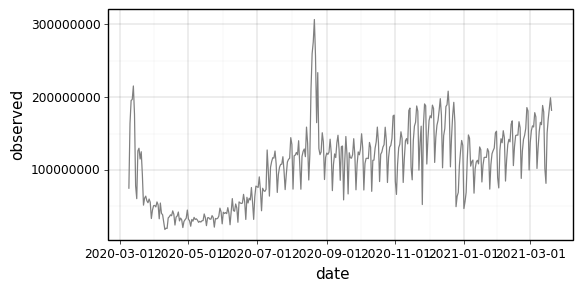

<ggplot: (8733763966757)>

In [16]:
gg=(p9.ggplot(data=df_cty.reset_index(),
           mapping=p9.aes(x='date', y='observed')) 
    + p9.geom_line(color = 'gray')
    + p9.theme(figure_size=(6, 3)))
gg

2021-03-21 14:51:15.996 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 14:51:15.997 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 14:51:15.997 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 14:51:15.998 | DEBUG    | __main__:_find_anomalies:100 - 
... finding outliers ...
2021-03-21 14:51:15.998 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 14:51:16.116 | DEBUG    | __main__:_find_anomalies:111 - Number of anomalies found: 16
2021-03-21 14:51:16.117 | DEBUG    | __main__:_find_anomalies:112 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-26 00:00:00'), Timestamp('2020-08-27 00:00:00'), Timestamp('2020-08-28 00:00:00'), Timestamp('2020-08-31 00:00:00'), Timestamp('2020-11-25 00:00:0

          date  anomaly_persist
0   2020-03-09              NaN
1   2020-03-10              NaN
2   2020-03-11              NaN
3   2020-03-12              NaN
4   2020-03-13              NaN
..         ...              ...
372 2021-03-16              0.0
373 2021-03-17              0.0
374 2021-03-18              0.0
375 2021-03-19              0.0
376 2021-03-20              0.0

[377 rows x 2 columns]
          date  anomaly_seasonal
0   2020-03-09             False
1   2020-03-10             False
2   2020-03-11             False
3   2020-03-12             False
4   2020-03-13             False
..         ...               ...
372 2021-03-16             False
373 2021-03-17             False
374 2021-03-18             False
375 2021-03-19             False
376 2021-03-20             False

[377 rows x 2 columns]
          date  anomaly_autor
0   2020-03-09            NaN
1   2020-03-10            NaN
2   2020-03-11            NaN
3   2020-03-12            NaN
4   2020-03-13        

/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/layer.py:464: PlotnineWarning: geom_point : Removed 361 rows containing missing values.


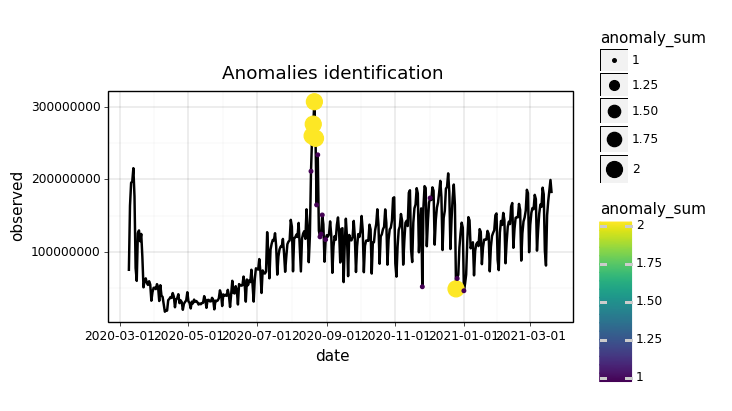

2021-03-21 14:51:16.581 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2021-03-21 14:51:16.619 | DEBUG    | __main__:_run_step:28 - Output variable S1_shift
2021-03-21 14:51:16.620 | DEBUG    | __main__:_shift_level:213 - 

2021-03-21 14:51:16.621 | DEBUG    | __main__:_shift_level:214 - ... shifting levels for Loess ...
2021-03-21 14:51:16.623 | DEBUG    | __main__:_validate_series:15 - ... validating Loess...

2021-03-21 14:51:16.629 | DEBUG    | __main__:_run_shift_grid:61 - 
... shift level running grid  ...


<ggplot: (8733764551777)>


2021-03-21 14:51:17.235 | DEBUG    | __main__:_run_shift_grid:79 - Total combinations: 25
2021-03-21 14:51:17.514 | DEBUG    | __main__:_initial_shift_date:143 - Shift found at 2020-07-06 00:00:00
2021-03-21 14:51:17.517 | DEBUG    | __main__:_shift_ts:161 - 

2021-03-21 14:51:17.517 | DEBUG    | __main__:_shift_ts:162 - Center point: -13806746.571428582
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/ipykernel_launcher.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/layer.py:464: PlotnineWarning: geom_point : Removed 9274 rows containing missing values.


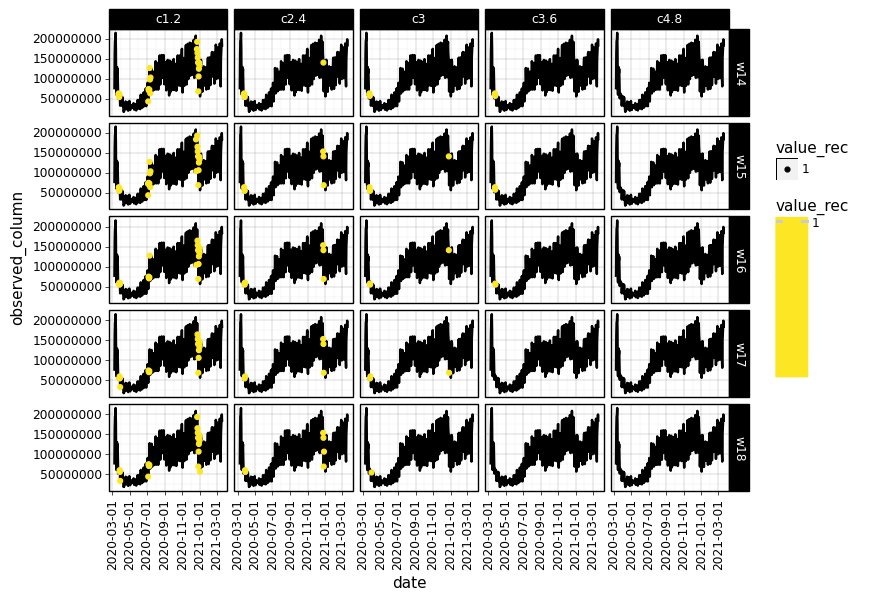

<ggplot: (8733764389113)>
Empty DataFrame
Columns: [date, shift_sum]
Index: []


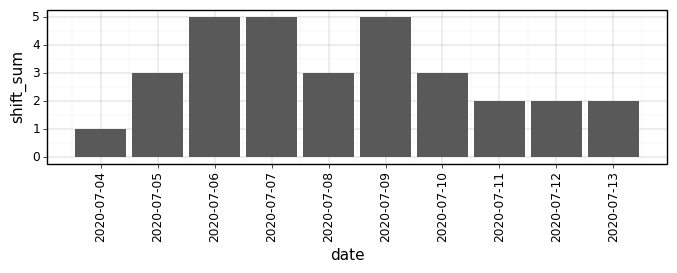

<ggplot: (8733764326905)>


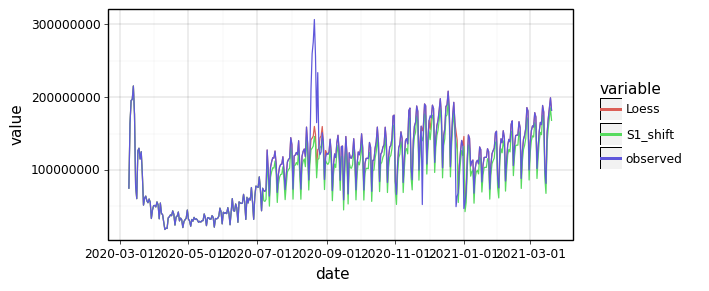

2021-03-21 14:51:30.680 | DEBUG    | __main__:_run_step:55 - ... step done ...


<ggplot: (8733753066445)>


In [17]:
df_run_1 = _run_step(df_run = df_cty.sort_values(by=['region_slug', 'date']),
                         anomaly_vote_minimun = 1, 
                         c_param=_c_param(region_slug),
                         target_column_name = 'observed',
                         output_column_name = 'S1_shift',
                         print_report = True, 
                         print_plot = True)

In [82]:
df_run_1.head()

,date,observed,Loess,S1_shift,outliers,level_shifts
0,2020-03-09,74001430,74001430,74001430.0,False,False
1,2020-03-10,163743625,163743625,163743625.0,False,False
2,2020-03-11,195417551,195417551,195417551.0,False,False
3,2020-03-12,196938136,196938136,196938136.0,False,False
4,2020-03-13,215453447,215453447,215453447.0,False,False


#### Second run

2021-03-21 15:02:35.560 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 15:02:35.560 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 15:02:35.561 | DEBUG    | __main__:_run_step:11 - Target variable: S1_shift 

2021-03-21 15:02:35.562 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 15:02:35.563 | DEBUG    | __main__:_validate_series:15 - ... validating S1_shift...

2021-03-21 15:02:35.662 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 5
2021-03-21 15:02:35.663 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-09-16 00:00:00'), Timestamp('2020-11-02 00:00:00'), Timestamp('2020-12-30 00:00:00'), Timestamp('2021-01-02 00:00:00'), Timestamp('2021-03-15 00:00:00')]
2021-03-21 15:02:35.665 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
2021-03-21 15:02:35.700 | DEBUG    | __main__:_run_step:28 - Output variable S2_shift
2021-03-21 15:02:35.701 | DEBUG    | __main__:_shift_

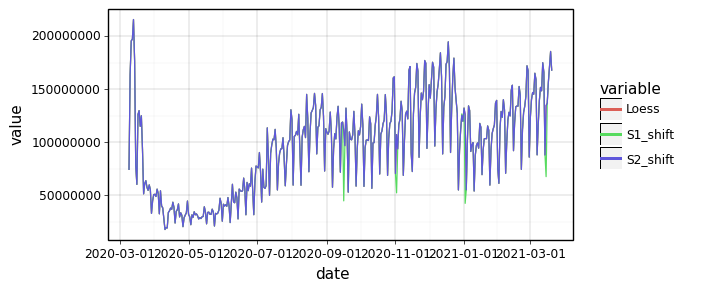

2021-03-21 15:02:37.125 | DEBUG    | __main__:_run_step:55 - ... step done ...


<ggplot: (8733751407213)>


In [58]:
df_run_2 = _run_step(df_run = df_run_1[['date', 'S1_shift']].sort_values(by=['date']),
                         anomaly_vote_minimun = 1, 
                         c_param=_c_param(region_slug),
                         target_column_name = 'S1_shift',
                         output_column_name = 'S2_shift',
                         print_report = False, 
                         print_plot = True)

In [221]:
qry = """
select 
    *
from spd_sdv_waze_corona.prod_daily_weekly_index
limit 10
"""
df = pd.read_sql_query(qry, conn)

In [226]:
df.columns #sort_values('week_number')

Index(['last_updated_utc', 'region_slug', 'region_name', 'country_name',
       'country_iso_code', 'country_idb_code', 'region_type', 'population',
       'timezone', 'week_number', 'min_year', 'min_month', 'min_day',
       'max_month', 'max_day', 'observed', 'expected_2020', 'ratio_20', 'tcp',
       'dashboard', 'region_shapefile_wkt'],
      dtype='object')